In [269]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F

if torch.cuda.is_available():  
    dev = torch.device("cuda:0")
else:
    dev = torch.device("cpu")
dev = torch.device("cpu")
print(f"Using {dev}")

Using cpu


MAX LENGTH:217


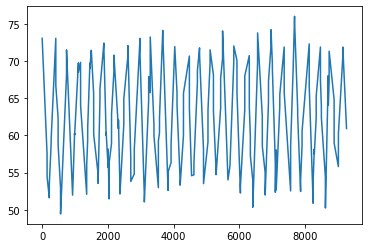

0
[[-0.06628468019995033, 0.6866359447004609], [-0.026941278742453115, 0.3087557603686636], [0.06197938416453149, 0.2534562211981567]]
output: [0.060961782854880256]
2
[[-0.026941278742453115, 0.3087557603686636], [0.06197938416453149, 0.2534562211981567], [0.060961782854880256, 0.6497695852534562]]
output: [-0.03984148053248929]
4
[[0.06197938416453149, 0.2534562211981567], [0.060961782854880256, 0.6497695852534562], [-0.03984148053248929, 0.31797235023041476]]
output: [-0.050281716530640196]
6
[[0.060961782854880256, 0.6497695852534562], [-0.03984148053248929, 0.31797235023041476], [-0.050281716530640196, 0.33640552995391704]]
output: [0.06551120097501582]
8
[[-0.03984148053248929, 0.31797235023041476], [-0.050281716530640196, 0.33640552995391704], [0.06551120097501582, 0.8341013824884793]]
output: [-0.06771872127654634]
10
[[-0.050281716530640196, 0.33640552995391704], [0.06551120097501582, 0.8341013824884793], [-0.06771872127654634, 0.8433179723502304]]
output: [0.08628377170623854

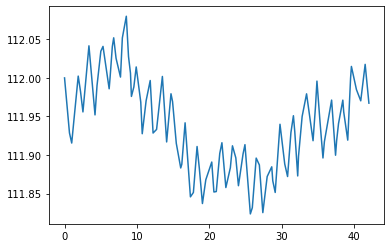

In [270]:
# ---- data loading and pre-processing ---- #

import polar_pla as pla
import numpy as np
import torch
from torch.autograd import Variable

# read in time series into temporary list
temp = []
f = open('DataSets/CTtemp.csv', 'r')
for line in f:
    temp.append(float(line))

# run bottom up piecewise linear approximation on that list and store processed values
data = pla.bottom_up_pla(temp,1000)
pla.display_trends(data, 112)
#print(data)
# set the sequence length (the number of trends we look at to predict the next) and the train to test ratio
seq_length = 3
train_proportion = 0.5

# segment the data into input output pairs that we will use to train the model
def sliding_window(data):
    inputs = []
    outputs = []
    for i in range(0, len(data)-seq_length*2, 2):
        print(i)
        temp = data[i:(i+seq_length*2)]
        new = []
        for x in range(0,len(temp),2):
            new.append([temp[x],temp[x+1]])
        #print(new)
        inputs.append(new)
        print(new)
        print("output: "+str(data[i+seq_length*2:i+seq_length*2+1]))
        #inputs.append(data[i:(i+seq_length*2)]) # the next n are the input
        #inputs.append([temp[::2],temp[1::2]])
        outputs.append(data[i+seq_length*2:i+seq_length*2+1]) # and the one after that is the output
    return Variable(torch.Tensor(np.array(inputs)).to(dev)), Variable(torch.Tensor(np.array(outputs)).to(dev))
# convert data to tensor, and apply dataloader
total_data_input, total_data_output = sliding_window(data)
train_size = int(len(total_data_input)*train_proportion)

training_data_input = torch.narrow(total_data_input, 0, 0, train_size)
training_data_output = torch.narrow(total_data_output, 0, 0, train_size)

testing_data_input = torch.narrow(total_data_input, 0, train_size, len(total_data_input) - train_size)
testing_data_output = torch.narrow(total_data_output, 0, train_size, len(total_data_input) - train_size)

train = torch.utils.data.TensorDataset(training_data_input, training_data_output)
test = torch.utils.data.TensorDataset(testing_data_input, testing_data_output)
trainset = torch.utils.data.DataLoader(train, batch_size=64, shuffle=False)
testset = torch.utils.data.DataLoader(test, batch_size=64, shuffle=False)

In [271]:
from torch import nn
from tcn import TemporalConvNet
import torch.nn.functional as F

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights()

    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')
            m.bias.data.fill_(0.01)

    def forward(self, x):
        y1 = self.tcn(x)
        return torch.tanh(self.linear(y1[:, :, -1]))

#net = TCN(seq_length,2,[2,64,64])#TCN(seq_length*2, 1, [2]*32)
net = TCN(seq_length,1, [128]*2, 2, 0.05)
net = net.to(dev)
print(net)

TCN(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(3, 128, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.05, inplace=False)
        (conv2): Conv1d(128, 128, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.05, inplace=False)
        (net): Sequential(
          (0): Conv1d(3, 128, kernel_size=(2,), stride=(1,), padding=(1,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.05, inplace=False)
          (4): Conv1d(128, 128, kernel_size=(2,), stride=(1,), padding=(1,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout(p=0.05, inplace=False)
        )
        (downsample): Conv1d(3, 128, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
      )
      (1): TemporalBlock(
        (conv1): Conv1d(128, 128, kernel_size=(2,), st

Epoch: 0/5000, loss: 0.08738330006599426
Epoch: 500/5000, loss: 0.002408724743872881
Epoch: 1000/5000, loss: 0.0015674624592065811
Epoch: 1500/5000, loss: 0.001224621431902051
Epoch: 2000/5000, loss: 0.0010606275172904134
Epoch: 2500/5000, loss: 0.0006291006575338542
Epoch: 3000/5000, loss: 0.0005561952712014318
Epoch: 3500/5000, loss: 0.00046667701099067926
Epoch: 4000/5000, loss: 0.00016391792451031506
Epoch: 4500/5000, loss: 0.00028175715124234557
Epoch: 5000/5000, loss: 0.00022829028603155166


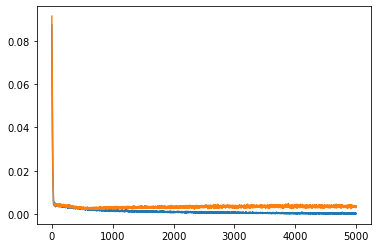

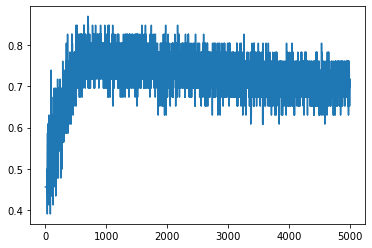

Lowest validation loss: 0.0021669375710189342 at epoch 601


In [272]:
# training

epochs = 5000

import torch.optim as optim
train_loss = []
validation_loss = []
net.train()
epoch_total_trainloss = 0 # the total loss for each epoch, used for plotting
min_val_loss_epoch = 0 # the epoch with the lowest validation loss
min_val_loss = 1000000 # the lowest validation loss
optimizer = optim.Adam(net.parameters(), lr=0.0001)
train_direction_accuracy = []
validation_direction_accuracy = []
for epoch in range(epochs+1):

    # this is the validation part, ideally we wouldn't do this every epoch, but it's easy and
    # gives good insight into when the model overfits
    for data in testset:
        torch.cuda.synchronize()
        features, labels = data  # split the batches up into their features and labels
        net.zero_grad()
        #print(features.shape)
        output = net(features)  # get a prediction from the model
        #print(output.shape)
        #print(labels.shape)
        output = output
        loss = F.mse_loss(output, labels)  # calculate the loss of our prediction
        epoch_total_trainloss += loss.item()/len(testset)
    
    if epoch_total_trainloss < min_val_loss:
        min_val_loss = epoch_total_trainloss
        min_val_loss_epoch = epoch

    validation_loss.append(epoch_total_trainloss) # we'll need to plot validation loss too
    epoch_total_trainloss = 0 # reset this for the validation epoch'''
    for data in trainset:  # for each batch
        torch.cuda.synchronize()
        features, labels = data  # split the batches up into their features and labels
        net.zero_grad()
        output = net(features)  # get a prediction from the model
        output = output
        #print(output.shape)
        loss = F.mse_loss(output, labels)  # calculate the loss of our prediction
        loss.backward()  # backpropogate the loss
        optimizer.step()  # optimize weights
        epoch_total_trainloss += loss.item()/len(trainset)  # sum the losses of this epoch
    
    train_loss.append(epoch_total_trainloss) # add this epoch's loss in order to plot it later
    epoch_total_trainloss = 0 # reset this for the validation epoch

    # now we'll calculate the direction accuracy for the training and validation sets
    correct=0
    for data in testset:
        torch.cuda.synchronize()
        inputs, labels = data
        output = net(inputs)
        for i in range(len(output)):
            pred = output[i]
            actual = labels[i]
            if pred < 0 and actual < 0 or pred > 0 and actual > 0:
                correct += 1
            #print(output[0],labels[0])
    validation_direction_accuracy.append(correct/len(test))

    if epoch %(epochs/10) == 0: print(f"Epoch: {epoch}/{epochs}, loss: {loss.item()}")

import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.plot(validation_loss)
plt.show()
plt.plot(validation_direction_accuracy)
plt.show()
print(f"Lowest validation loss: {min_val_loss} at epoch {min_val_loss_epoch}")

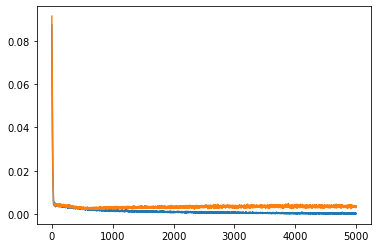

Directional Accuracy: 73.91304347826087


In [274]:
# test
plt.plot(train_loss)
plt.plot(validation_loss)
plt.show()

correct=0
output_file = open("angles.txt", "w")
for data in trainset:
    inputs, labels = data
    output = net(inputs)
    for i in range(len(output)):
        pred = output[i]
        output_file.write(str(pred.item()*90)+"\n")

for data in testset:
    inputs, labels = data
    output = net(inputs)
    for i in range(len(output)):
        pred = output[i]
        actual = labels[i]
        if pred < 0 and actual < 0 or pred > 0 and actual > 0:
            correct += 1
        output_file.write(str(pred.item()*90)+"\n")
print(f'Directional Accuracy: {correct*100/len(test)}')